In [1]:
import chess
import chess.engine
import os
import copy
from pathlib import Path
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
import random
import pandas as pd

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

chess_dict = {
    'P_l': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'P_r': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'p':   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'N_l': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'N_r': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'n':   [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'B_l': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'B_r': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'b':   [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'R_l': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    'R_r': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    'r':   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'q':   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Q':   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    'k':   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    'K':   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    '.':   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
}

num2move = {}
move2num = {}

counter = 0
for from_sq in range(64):
    for to_sq in range(64):
        num2move[counter] = chess.Move(from_sq, to_sq)
        move2num[chess.Move(from_sq, to_sq)] = counter
        counter += 1
        
        
def translate_board(board):
    pgn = board.epd()
    foo = []
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []
        for index, thing in enumerate(row):
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append(chess_dict['.'])
            else:
                if thing not in ["P", "N", "R", "B"]:
                    foo2.append(chess_dict[thing])
                else:
                    if(index < 4):
                        foo2.append(chess_dict[thing+"_l"])
                    else:
                        foo2.append(chess_dict[thing+"_r"])
        foo.append(foo2)
    return np.array(foo)
        
def find_piece_key(piece_representation):
    index = np.argmax(piece_representation)
    piece_key = ""
    for key in chess_dict:
        if index == np.argmax(chess_dict[key]):
            piece_key = key
            break
    return piece_key


def can_move(move, agent_num, translated_board):
    from_square = move.from_square
    piece = translated_board[7-from_square//8][from_square % 8]
    piece_key = find_piece_key(piece)
    if agent_num == 0 and "_l" in piece_key:
        return True
    if agent_num == -1 and "_r" in piece_key:
        return True
    if "Q" in piece_key or "K" in piece_key:
        return True
    return False


def filter_legal_moves(board, logits, agent_num, translated_board):
    filter_mask = np.zeros(logits.shape)
    legal_moves = board.legal_moves
    num_legal_mobes = list(board.legal_moves)
    for legal_move in legal_moves:
        if agent_num is not None:
            if(can_move(legal_move, agent_num, translated_board)):
                from_square = legal_move.from_square
                to_square = legal_move.to_square
                idx = move2num[chess.Move(from_square, to_square)]
                filter_mask[idx] = 1
        else:
            from_square = legal_move.from_square
            to_square = legal_move.to_square
            idx = move2num[chess.Move(from_square, to_square)]
            filter_mask[idx] = 1
    new_logits = logits*filter_mask
    return new_logits


def check_legal_move(board, move):
    legal_moves = board.legal_moves
    legal = False
    for legal_move in legal_moves:
        from_square = legal_move.from_square
        to_square = legal_move.to_square
        if from_square == move.from_square and to_square == move.to_square:
            legal = True
            break

    return legal


In [3]:
class StockFishEngine:
    def __init__(self) -> None:
        self.engine = chess.engine.SimpleEngine.popen_uci(
            os.path.join("stockfish", "stockfish_15_x64_avx2.exe")
        )
    def move(self, board):
        result = self.engine.play(board, chess.engine.Limit(time=0.01))
        return result.move

    def quit(self):
        self.engine.quit
        
class ChessEnv():
    def __init__(self):
        self.stockFishEngine = StockFishEngine()
        pass

    def reset(self):
        self.board = chess.Board()
        self.translated_board = translate_board(self.board)
        return self.translated_board

    def step(self, action):
        reward = 0
        self.board.push(action)
        self.update_translated_borad(action)
        if self.board.is_checkmate():
            reward = 1
        else:
            action = self.stockFishEngine.move(self.board)
            self.board.push(action)
            self.update_translated_borad(action)
            if self.board.is_checkmate():
                reward = -1
      
        state_next = self.translated_board
        self.done = self.board.is_checkmate()
        return state_next, reward, self.done, None
    
    
    def preprocess(self, board):
        pgn = board.epd()
        processed_board = []
        pieces = pgn.split(" ", 1)[0]
        rows = pieces.split("/")
        
        for row in rows:
            processed_row = []
            for index, element in enumerate(row):
                if element.isdigit():
                    for i in range(0, int(element)):
                        processed_row.append(chess_dict['.'])
                else:
                    if element not in ["P", "N", "R", "B"]:
                        processed_row.append(chess_dict[element])
                    else:
                        if(index < 4):
                            processed_row.append(chess_dict[element+"_l"])
                        else:
                            processed_row.append(chess_dict[element+"_r"])
            processed_board.append(processed_row)
        return np.array(processed_board)
    
    def update_translated_borad(self, action):
        from_square = action.from_square
        to_square = action.to_square
        tmp = self.translated_board[7-from_square//8][from_square % 8].copy()
        self.translated_board[7-from_square//8][from_square %
                                                8] = self.translated_board[7-to_square//8][to_square % 8]
        self.translated_board[7-to_square//8][to_square % 8] = tmp



class ReplayMemory:
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
  def __init__(self, obs_shape, n_actions):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(obs_shape[0], 64, kernel_size=2,stride=2),
        nn.Conv2d(64, 128, kernel_size=2,stride=2),
        nn.Conv2d(128, 256, kernel_size=2,stride=2),
    )
    conv_out_size = self._get_conv_out(obs_shape)
    
    self.fc = nn.Linear(conv_out_size, 512)
    self.fc_adv = nn.Linear(512, n_actions) 
    self.fc_value = nn.Linear(512, 1)

  def _get_conv_out(self, shape):
    conv_out = self.conv(torch.zeros(1, *shape))
    return int(np.prod(conv_out.size()))

  def forward(self, x):
    x = self.conv(x.float()).view(x.size()[0], -1)
    x = self.fc(x)
    adv = self.fc_adv(x)
    value = self.fc_value(x)
    x = value + adv - torch.mean(adv, dim=1, keepdim=True)
    return torch.softmax(x, dim=1)

In [4]:
env = ChessEnv()
state = env.reset()
obs_size = state.shape
num_actions = 4096
q_network = DQN(obs_size, num_actions).to(device)
target_q_network = copy.deepcopy(q_network).eval().to(device)

def policy(state, agent_num = None, epsilon=0.):
    if torch.rand(1) < epsilon:
        action_probs = 1 * 2 + np.random.uniform(0, 1, 4096)
        action_space = filter_legal_moves(env.board, action_probs, agent_num, env.translated_board)
        action_space = torch.from_numpy(action_space)
        action = torch.argmax(action_space, dim=-1, keepdim=True)
        move = num2move[action.item()]
        return action, move
    else:
        action_probs = q_network(state).detach()
        action_space = filter_legal_moves(env.board, action_probs[0], agent_num, env.translated_board)
        action =  torch.argmax(action_space, dim=-1, keepdim=True)
        move = num2move[action.item()]
        return action, move


def deep_q_learning(q_network, policy, episodes, alpha=0.0001, batch_size=32, gamma=0.99, epsilon=0.2):
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
    stats = {'MSE Loss': [], 'Returns': [], "Game duration":[]}
    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        state = torch.from_numpy(state).unsqueeze(dim=0)
        done = False
        ep_return = 0
        duration = 0
        agent_num = 0
        while not done:
            state = state.float().to(device)
            action, move = policy(state, agent_num, epsilon)
            if action == 0:
                action, move = policy(state, ~agent_num, epsilon)
            
            duration += 1
            next_state, reward, done, _ = env.step(move)
            agent_num = ~agent_num
            next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
            reward = torch.tensor(reward).view(1, -1).float()
            done = torch.tensor(done).view(1, -1).bool()
            action = action.view(1, -1)
           

            memory.insert([state, action, reward, done, next_state])
            
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                state_b = state_b.to(device)
                reward_b = reward_b.to(device)
                action_b = action_b.to(device)
                done_b = done_b.to(device)
                next_state_b = next_state_b.float().to(device)
                qsa_b = q_network(state_b).gather(1, action_b)
                next_qsa_b = target_q_network(next_state_b)
                next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]
                next_qsa_b.float().to(device)
                target_b = reward_b + ~done_b * gamma * next_qsa_b
                loss = F.mse_loss(qsa_b.float(), target_b.float())
                q_network.zero_grad()
                loss.backward()
                optim.step()
                stats['MSE Loss'].append(loss.item())  
                
            state = next_state
            ep_return += reward.item()
        stats['Returns'].append(ep_return)
        stats['Game duration'].append(duration)
        if episode % 10 == 0:            
            target_q_network.load_state_dict(q_network.state_dict())
    return stats

In [5]:
stats = deep_q_learning(q_network,policy,10000)

100%|██████████| 10000/10000 [4:07:04<00:00,  1.48s/it]     


In [6]:
loss_df = pd.DataFrame(stats["MSE Loss"], columns=["MSE Loss"])
loss_df['ID'] = range(1, len(loss_df) + 1)
loss_df.set_index('ID', inplace=True)
reward_df = pd.DataFrame(stats["Returns"], columns=["Returns"])
reward_df['ID'] = range(1, len(reward_df) + 1)
reward_df.set_index('ID', inplace=True)
duration_df = pd.DataFrame(stats["Game duration"], columns=["Game duration"])
duration_df['ID'] = range(1, len(duration_df) + 1)
duration_df.set_index('ID', inplace=True)

In [13]:
loss_df.to_csv("./metrices/multi-agent-duelling-q-learning-loss")
reward_df.to_csv("./metrices/multi-agent-duelling-q-learning-reward")
duration_df.to_csv("./metrices/multi-agent-duelling-q-learning-duration")

In [7]:
def save(model, path):
    torch.save(model.state_dict(), path)    

def load(path,n_actions,state_size, embedding_size):
    model = DQN(n_actions,state_size,embedding_size)
    model.load_state_dict(torch.load(path))
    return model 
save(q_network,"./models/multi-agent-duelling-q-learning")

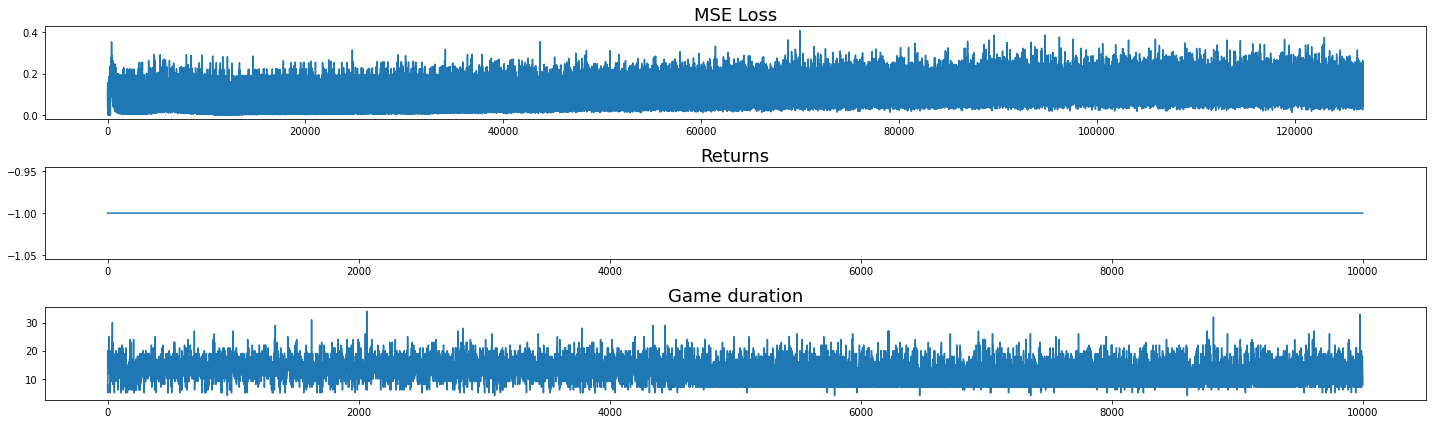

In [8]:
import matplotlib.pyplot as plt 

def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(20, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        #vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    #plt.savefig("experiment1_1.pdf",dpi=600,bbox_inches = 'tight',pad_inches = 0.1)
    plt.show()
    
plot_stats(stats)